# Basic Analysis

## Tweet and user volume

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import itertools
import collections
from datetime import datetime
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')

In [3]:
#number of total tweets
print(df.shape[0])
#number of total unique users
print(len(pd.unique(df['author.id'])))

116928
19010


In [4]:
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_date = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [5]:
#List the distribution of languages in the tweets (important for preprocessing (stopwords etc.))
print(df_date['lang'].value_counts())

de     99219
en     13648
und     3147
fr       302
ja        61
es        52
nl        51
it        32
is        29
da        21
pt        20
no        18
lt        17
tr        16
ca        14
pl        14
sv        14
ro         6
hi         4
et         4
cs         3
in         3
ar         3
tl         3
fi         3
lv         3
fa         2
cy         2
ht         2
vi         1
zh         1
ru         1
eu         1
Name: lang, dtype: int64


As tweets with undefined language mostly consist of only hashtags, URls or emojis, they will be discarded. Otherwise only german and english tweets are kept for the analysis

In [6]:
df_date = df_date.loc[(df_date['lang'] == "de") | (df_date['lang'] == "en")]

In [7]:
pd.set_option('display.max_rows', 100)
#number of remaining tweets
print(df_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_date['author.id'])))
#overview over "missing values"
print(df_date.count())

112867
18534
__twarc.retrieved_at                                95949
__twarc.url                                         95949
__twarc.version                                     95949
attachments.media                                    2774
attachments.media_keys                               2774
attachments.poll.duration_minutes                      83
attachments.poll.end_datetime                          83
attachments.poll.id                                    83
attachments.poll.options                               83
attachments.poll.voting_status                         83
attachments.poll_ids                                   88
author.created_at                                  112867
author.description                                 107368
author.entities.description.cashtags                    9
author.entities.description.hashtags                39280
author.entities.description.mentions                49795
author.entities.description.urls                     7509
a

<AxesSubplot:xlabel='week'>

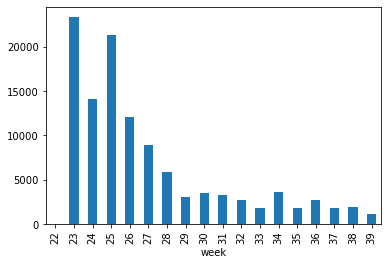

In [8]:
week_groups = df_date.groupby([pd.to_datetime(df_date['new_date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [9]:
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]

<AxesSubplot:xlabel='new_date'>

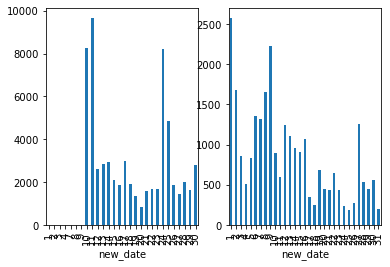

In [10]:
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
june_groups.plot(kind='bar', legend = False)
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
july_groups.plot(kind='bar', legend = False)

<AxesSubplot:xlabel='new_date'>

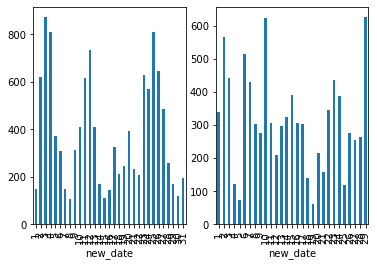

In [11]:
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
august_groups.plot(kind='bar', legend = False)
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
september_groups.plot(kind='bar', legend = False)

## Missing Hashtag-Problem

In [12]:
#number of tweets actually containing the hashtag
df_hash = df_date[df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_hash.shape[0])

60832


In [13]:
#number of tweets not containing the hashtag directly
df_no_hash = df_date[-df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_no_hash.shape[0])

52035


In [14]:
#number of tweets without the hashtag that are retweets (text from original tweet cut off)
print(df_no_hash[df_no_hash['reference_type'] == 'retweeted'].shape[0])
#number of tweets with the hashtag that are retweets
print(df_hash[df_hash['reference_type'] == 'retweeted'].shape[0])

47468
40896


In [15]:
print(df_hash['reference_type'].value_counts())
print(df_no_hash['reference_type'].value_counts())

retweeted       40896
no_reference     8159
quoted           6205
replied_to       5572
Name: reference_type, dtype: int64
retweeted       47468
replied_to       2760
no_reference     1253
quoted            554
Name: reference_type, dtype: int64


As a majority of those tweets are retweets that are mostly cut off due to the character constraint, a first approach is to exclude retweets directly for the sentiment analysis, as the original tweet (as long as it falls into our time frame) is most likely in the collection as well. If certain users or networks have to be observed, the whole data set might be of more interest.

In [16]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df_no_hash.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Get top hashtags appearing in tweets along with #IchBinHanna in september

In [17]:
#make the hashtags a list of strings, then adapt the monthly data frames, also remove tweets not containing the hashtag,
#but keep retweets for this part of the analysis
df_date['hashtags'] = df_hash['hashtags'].str.replace('[', '').str.replace(']','')
df_date['hashtags separated'] = df_date['hashtags'].str.split(',')
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]

In [18]:
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags = df_september['hashtags separated'].explode().to_frame().dropna()
flat_hashtags = flat_hashtags[-flat_hashtags['hashtags separated'].str.contains("ichbinhanna", case = False)]

In [19]:
#count occurences 
hashtag_count = flat_hashtags.value_counts()
hashtag_count = hashtag_count[hashtag_count > 10].reset_index()

In [20]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='top_hashtags.csv')  
hashtag_count.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Identify Events by observing spikes in tweet volume

In [21]:
print("Highest activity in June:\n{}".format(june_groups.sort_values(ascending = False).head(10)))
print("Highest activity in July:\n{}".format(july_groups.sort_values(ascending = False).head(10)))
print("Highest activity in August:\n{}".format(august_groups.sort_values(ascending = False).head(10)))
print("Highest activity in September:\n{}".format(september_groups.sort_values(ascending = False).head(10)))

Highest activity in June:
new_date
11    9654
10    8244
24    8228
25    4833
17    3003
14    2942
13    2830
30    2794
12    2595
15    2119
dtype: int64
Highest activity in July:
new_date
1     2574
9     2222
2     1686
8     1659
6     1357
7     1317
27    1259
12    1242
13    1108
16    1066
dtype: int64
Highest activity in August:
new_date
3     872
4     811
25    807
12    733
26    645
23    629
2     618
11    617
24    571
27    486
dtype: int64
Highest activity in September:
new_date
29    626
10    622
2     566
6     514
3     442
23    435
7     429
15    390
24    388
22    344
dtype: int64


### First approach: search for most frequent words in tweets with the hashtag for the days with the highest activity

Retweets are kept here, as they give an indication about the engagement of a topic and reflect that in a higher word count for frequently discussed themes.

In [22]:
#First step: process the raw text data
#remove linebreaks separately
df_date['processed text'] = df_date['text'].replace(r'\\n',  ' ', regex=True)
#function to remove URLs, punctuation, @ etc. (source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_date['processed text'] = df_date['processed text'].apply(rem_url)

In [23]:
#lowercases and tokenize text
df_date['processed text'] = df_date['processed text'].str.lower().str.split()

In [24]:
#remove german and english stopwords (separately for the given language of a tweet)
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_date['processed w/o stopwords'] = df_date[['processed text','lang']].apply(lambda x: ' '.join([word for word in x['processed text'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed text'] if word not in (german_stop)]).split(),axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_date['processed w/o stopwords'] = df_date['processed w/o stopwords'].apply(lambda x: [word for word in x if len(word) > 1])

In [26]:
#most frequent words overall
all_words = list(itertools.chain(*df_date['processed w/o stopwords']))
total_word_count = collections.Counter(all_words)
total_word_count.most_common(25)

[('rt', 88536),
 ('ichbinhanna', 59241),
 ('amreibahr', 12013),
 ('innen', 10710),
 ('amp', 10062),
 ('bmbf', 9649),
 ('bund', 9601),
 ('wissenschaft', 8496),
 ('wisszeitvg', 7511),
 ('wissenschaftler', 6419),
 ('hanna', 6396),
 ('drkeichhorn', 6047),
 ('mehr', 4953),
 ('anjakarliczek', 4615),
 ('mal', 4503),
 ('viele', 4404),
 ('heute', 3939),
 ('german', 3926),
 ('system', 3738),
 ('ja', 3725),
 ('schon', 3354),
 ('gibt', 3332),
 ('geht', 3207),
 ('jahre', 3126),
 ('uni', 3124)]

In [27]:
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_date['processed w/o stopwords'] = df_date[['processed w/o stopwords','lang']].apply(lambda x: ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)

In [28]:
#get most frequent terms for days with highest tweet volume per month
current_day = df_date.loc[(df_date['new_date'] > '2021-06-10 00:00:00') & (df_date['new_date'] <= '2021-06-10 23:59:59')]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-11 00:00:00') & (df_date['new_date'] <= '2021-06-11 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("11.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-24 00:00:00') & (df_date['new_date'] <= '2021-06-24 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("24.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-25 00:00:00') & (df_date['new_date'] <= '2021-06-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-17 00:00:00') & (df_date['new_date'] <= '2021-06-17 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("17.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-30 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("30.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-01 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("01.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-02 00:00:00') & (df_date['new_date'] <= '2021-07-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-09 00:00:00') & (df_date['new_date'] <= '2021-07-09 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("09.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-08 00:00:00') & (df_date['new_date'] <= '2021-07-08 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("08.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-03 00:00:00') & (df_date['new_date'] <= '2021-08-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-04 00:00:00') & (df_date['new_date'] <= '2021-08-04 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("04.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-25 00:00:00') & (df_date['new_date'] <= '2021-08-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-12 00:00:00') & (df_date['new_date'] <= '2021-08-12 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("12.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-26 00:00:00') & (df_date['new_date'] <= '2021-08-26 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("26.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-29 00:00:00') & (df_date['new_date'] <= '2021-09-29 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("29.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-10 00:00:00') & (df_date['new_date'] <= '2021-09-10 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-02 00:00:00') & (df_date['new_date'] <= '2021-09-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-06 00:00:00') & (df_date['new_date'] <= '2021-09-06 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("06.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-03 00:00:00') & (df_date['new_date'] <= '2021-09-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.09.:\n{}".format(daily_word_count.most_common(25)))

10.06.:
[('wissenschaftler', 1188), ('befristet', 839), ('jahre', 816), ('wisszeitvg', 798), ('teilen', 793), ('bmbf', 790), ('wissenschaft', 743), ('de', 706), ('seit', 645), ('prekären', 603), ('nachwuchs', 578), ('stelle', 558), ('momentan', 530), ('status', 530), ('angestellte', 529), ('degneranja', 529), ('bund', 499), ('forsche', 465), ('befristete', 452), ('promoviert', 437), ('jahren', 435), ('system', 431), ('german', 393), ('12', 371), ('viele', 359)]
11.06.:
[('wissenschaftler', 950), ('wissenschaft', 910), ('system', 885), ('german', 840), ('viele', 728), ('bmbf', 692), ('teilen', 600), ('academic', 599), ('trending', 589), ('bund', 571), ('jahre', 566), ('gerade', 485), ('wisszeitvg', 450), ('uni', 440), ('germany', 415), ('academia', 400), ('stelle', 392), ('befristet', 384), ('de', 377), ('since', 371), ('befristungen', 370), ('seit', 360), ('know', 336), ('martin', 327), ('ok', 314)]
24.06.:
[('hannaimbundestag', 1433), ('anjakarliczek', 796), ('wissenschaft', 609), ('h

### Observations June:
10th + 11th: Start of the movement under the hashtag #IchBinHanna
24th: Issue got discussed in the "aktuelle Stunde" of the german Bundestag
25th: Series of tweets of Achim Landwehr, a Dean of studies critizing and portraying the situation of scientific workers
17th: State scecretary Wolf-Dieter Lukas uploads a video addressing the issues that arose with the hashtag
14th: Initial video of the BMBF gets deleted from their website.

### Observations July:
1st +  2nd: Zoom conference of the GEW (union for education and science) 
9th: Journalist Thilo Jung presents the issue at a press conference of the german government 

### Observations August:
3rd + 4th: TV report about #IchBinHanna in ZDF's "heute journal" 

### Observations September:
2nd + 3rd: declaration of new "Berliner Hochschulgesetz"
29th: IchBinHanna discussed in the "hessischer Landtag"